(1702, 17)


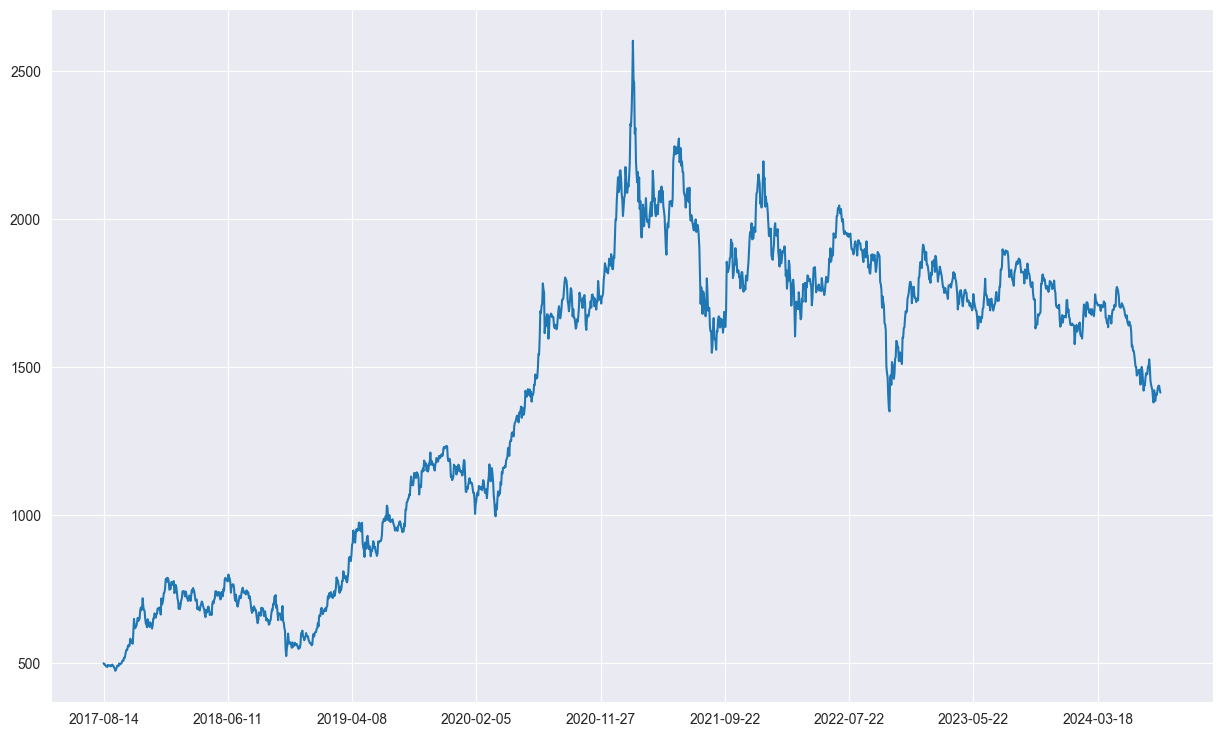

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filepath = '../data/600519.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
print(data.shape)

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data['Date'],data['Close'])
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 
plt.show()

## 1.特征工程

In [404]:
# 选取Close作为特征
price = data[['Close']]
# 选曲后20%的数据
# split = int(0.1 * len(price))
# price= price[-split:]
print(price.info())

from sklearn.preprocessing import MinMaxScaler
# 进行不同的数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))
print(price['Close'].shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 1701
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1702 non-null   float64
dtypes: float64(1)
memory usage: 26.6 KB
None
(1702,)


C:\Users\Chixiyu\AppData\Local\Temp\ipykernel_75540\1102515358.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



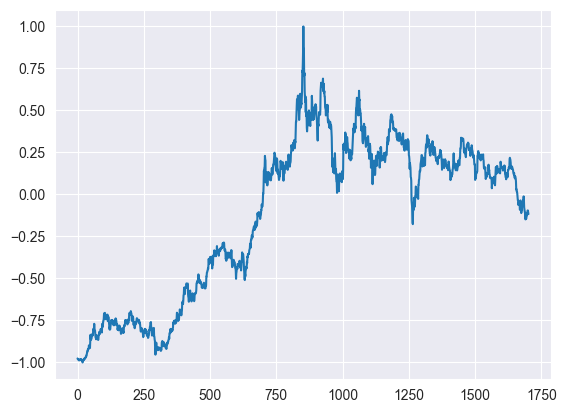

In [405]:
plt.plot(price['Close'])

## 2.数据集制作

In [406]:
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
# def split_data(stock, lookback):
#     data_raw = stock.to_numpy()
#     data = []
#     # print(data)

#     # you can free play（seq_length）
#     for index in range(len(data_raw) - lookback):
#         data.append(data_raw[index: index + lookback])

#     data = np.array(data)
#     test_set_size = int(np.round(0.2 * data.shape[0]))
#     train_set_size = data.shape[0] - (test_set_size)

#     x_train = data[:train_set_size, :-1, :]
#     y_train = data[:train_set_size, -1, :]

#     x_test = data[train_set_size:, :-1]
#     y_test = data[train_set_size:, -1, :]

#     return [x_train, y_train, x_test, y_test]


# lookback = 20
# X_train, y_train, x_test, y_test = split_data(price, lookback)
# print('x_train.shape = ', x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ', y_test.shape)



def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

from sklearn.model_selection import train_test_split

lookback=20

X, y = create_sequences(price[['Close']].values, lookback)
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.1,shuffle=False,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1513, 20, 1), (169, 20, 1), (1513, 1), (169, 1))

In [407]:
# shuffle training dataset
# indices = np.random.permutation(len(X_train))
# X_train = X_train[indices]
# y_train = y_train[indices]

## 3.模型构建 —— LSTM_KAN

In [408]:
# 注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)
# 3.模型构建 —— LSTM

import torch
import torch.nn as nn
from fastkan import FastKAN as KAN
import torch.nn.functional as F

X_train=torch.from_numpy(X_train).to(torch.float32)
X_test=torch.from_numpy(X_test).to(torch.float32)

y_train_lstm = torch.from_numpy(y_train).to(torch.float32)
y_test_lstm = torch.from_numpy(y_test).to(torch.float32)
# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 200

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTM_KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_KAN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True)
        # self.fc1=nn.Linear(hidden_dim*2,output_dim)
        self.kan=KAN([hidden_dim*2, output_dim])

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.kan(out[:, -1, :])
        # out = self.fc1(out[:, -1, :])
        return out



model = LSTM_KAN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=0.0001)

## 4.模型训练

In [409]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(X_train.to(device))

    loss = criterion(y_train_pred, y_train_lstm.to(device))
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.43436384201049805
Epoch  1 MSE:  5.962035179138184
Epoch  2 MSE:  1.5446922779083252
Epoch  3 MSE:  0.40799739956855774
Epoch  4 MSE:  0.21068763732910156
Epoch  5 MSE:  0.14225372672080994
Epoch  6 MSE:  0.02138488180935383
Epoch  7 MSE:  0.09445737302303314
Epoch  8 MSE:  0.03675900399684906
Epoch  9 MSE:  0.030795171856880188
Epoch  10 MSE:  0.08367732912302017
Epoch  11 MSE:  0.025186045095324516
Epoch  12 MSE:  0.01186047587543726
Epoch  13 MSE:  0.046087685972452164
Epoch  14 MSE:  0.022501306608319283
Epoch  15 MSE:  0.013357378542423248
Epoch  16 MSE:  0.03884896636009216
Epoch  17 MSE:  0.025723230093717575
Epoch  18 MSE:  0.00450521195307374
Epoch  19 MSE:  0.017411410808563232
Epoch  20 MSE:  0.020457804203033447
Epoch  21 MSE:  0.005423578433692455
Epoch  22 MSE:  0.010760943405330181
Epoch  23 MSE:  0.019756540656089783
Epoch  24 MSE:  0.008510250598192215
Epoch  25 MSE:  0.0039382693357765675
Epoch  26 MSE:  0.011832200922071934
Epoch  27 MSE:  0.00842745

## 5.模型结果可视化

In [410]:
X=torch.from_numpy(X).to(torch.float32).to(device)
X.shape

torch.Size([1682, 20, 1])

In [411]:
X.shape,price.shape

(torch.Size([1682, 20, 1]), (1702, 1))

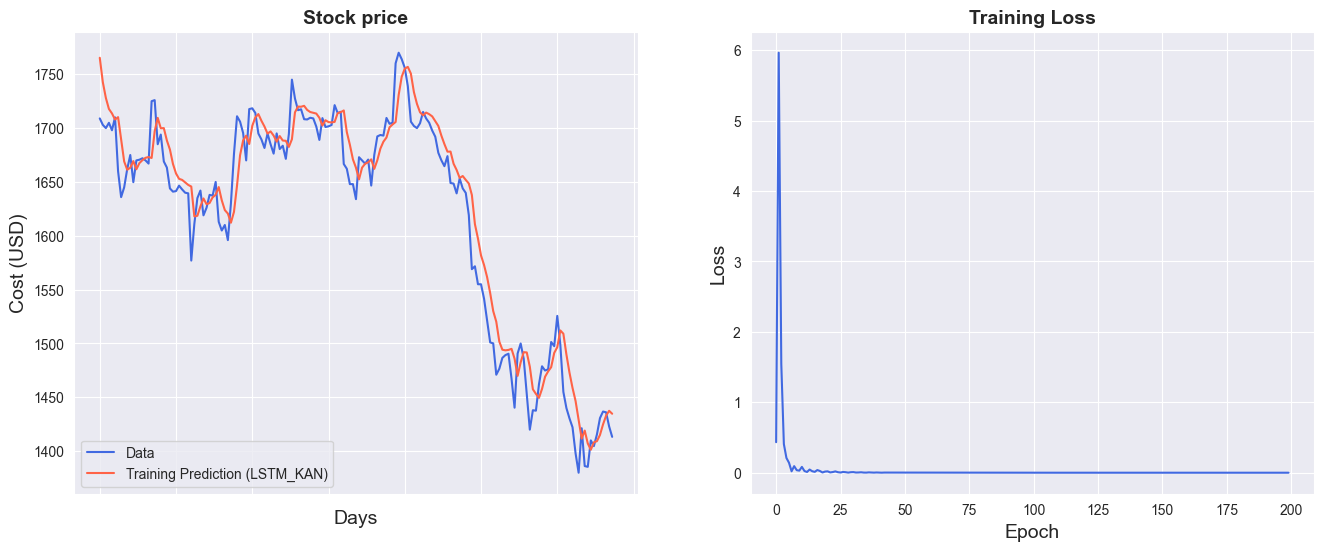

In [412]:
predict = pd.DataFrame(scaler.inverse_transform(model(X_test.to(device)).detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_test))


import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM_KAN)", color='tomato')
# print(predict.index)
# print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## 6.模型验证

In [417]:
# print(x_test[-1])
import math, time
from sklearn.metrics import mean_squared_error,r2_score

# make predictions
y_test_pred = model(X_test.to(device))


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0].cpu().detach().numpy()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0].cpu().detach().numpy()))
print('Test Score: %.2f RMSE' % (testScore))

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

trainr2Score = r2_score(y_train[:,0], y_train_pred[:,0])
print('Train Score: %.2f R2' % (trainr2Score))
testr2Score = r2_score(y_test[:,0], y_test_pred[:,0])
print('Test Score: %.2f R2' % (testr2Score))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

Train Score: 0.03 RMSE
Test Score: 0.02 RMSE
Train Score: 1.00 R2
Test Score: 0.94 R2


## 7. 绘制图像

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM_KAN)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()